In [4]:
# Imports & Inits

from datetime import datetime
from datetime import timezone
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import pyarrow as pa
import numpy as np
import os

quickflow_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"

df_quickflow = pl.scan_parquet(os.path.join(quickflow_directory, "measurements.parquet")) 

def plot_sensor_measurement(df_f, variant: str, col_name: str, sensor_id: int, filter = None):
    
    if filter != None:
            df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

    sns.lineplot(data=df_f,
            x='date',
            y=col_name,
            label = id)


    # set axes labels
    plt.xlabel('Time')
    plt.ylabel(col_name)
    plt.xticks(rotation=45)
    plt.legend(title='Systems', bbox_to_anchor=(1, 1))
    plt.title(label=col_name)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

    # show the plot
    plt.show()
        
def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    # 
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    # y_true = m * y_meas + t
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

def average_bottle(conc_list):
    uncut_avg = sum(conc_list) / len(conc_list)
    print(f"Uncut average: {uncut_avg}")

    if len(conc_list) > 0:
        conc_list_cut = conc_list[int(len(conc_list)*0.3):int(len(conc_list)*0.95)]
        cut_avg = sum(conc_list_cut) / len(conc_list_cut)
        print(f"Cut average: {cut_avg}")
    
        return cut_avg
    return 0

In [5]:
def extract_calibration_period(sensor_id, start_date, end_date):
    df = pl.scan_parquet("/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old/old_db_measurements.parquet")
    df = df.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("date").filter(pl.col("date").is_between(start_date, end_date))
    return df.collect()

# Before Site-by-Site

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

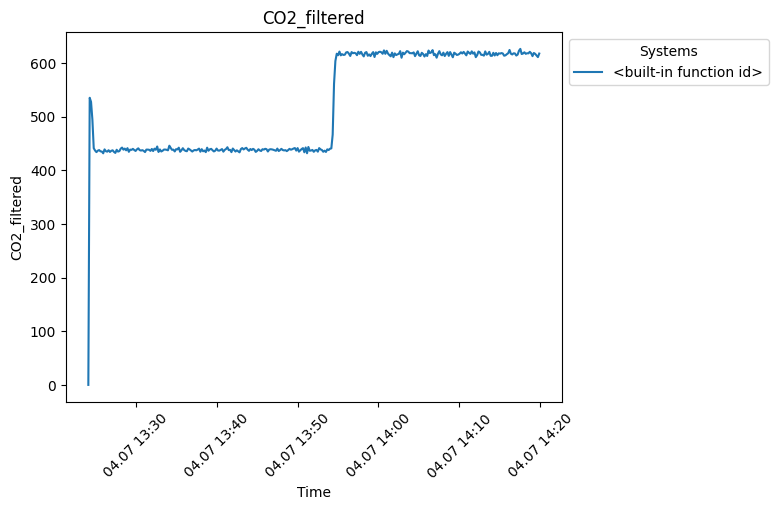

In [6]:
sensor_id = 1

#calibration time
start_date = datetime(2023, 7, 4, 13, 20, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 7, 4, 14, 20, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(sensor_id, start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [7]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)

617.054901960784
617.5699999999998
439.4779005524861
438.19999999999993


(1.0234152868372646, -21.08057869208926)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

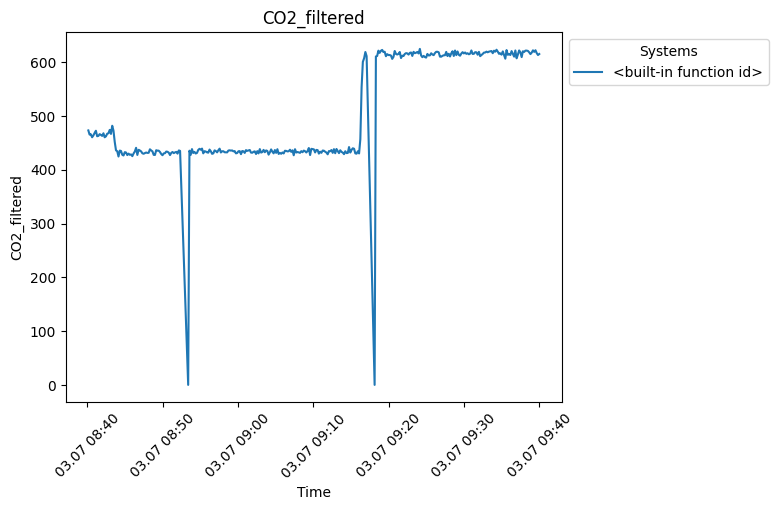

In [8]:
sensor_id = 11

#calibration time
start_date = datetime(2023, 7, 3, 8, 40, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 7, 3, 9, 40, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(sensor_id,start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

# Before Deployment

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

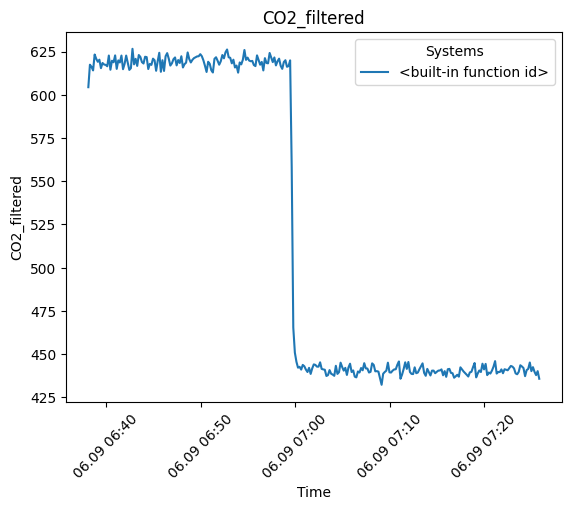

In [9]:
sensor_id = 1

#calibration time
start_date = datetime(2023, 9, 6, 6, 38, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 6, 7, 26, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(sensor_id,start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [10]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


618.6330769230766
619.4761904761906
440.85414012738846
440.40000000000015


(1.0250943998298148, -24.071573685050566)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

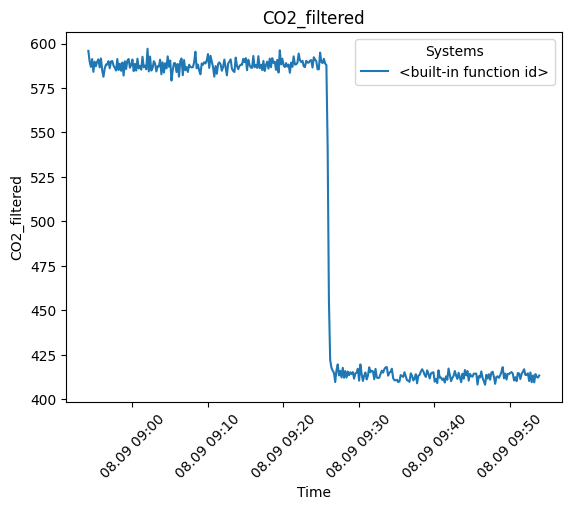

In [11]:
sensor_id = 2

#calibration time
start_date = datetime(2023, 9, 8, 8, 54, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 8, 9, 54, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(sensor_id,start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [12]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


588.1236842105264
588.087804878049
414.4171597633138
412.93181818181824


(1.0480372578892292, -5.387930422486534)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

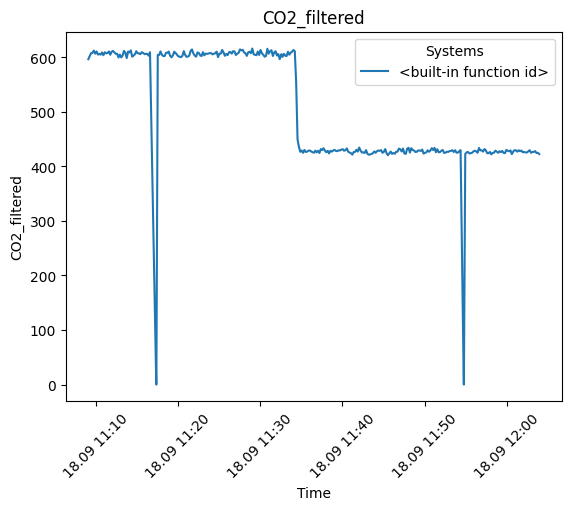

In [13]:
sensor_id = 3

#calibration time
start_date = datetime(2023, 9, 18, 11, 9, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 18, 12, 4, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(sensor_id,start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [14]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


606.5527027027026
606.7843750000001
427.6891428571429
427.37368421052605


(1.0231831737129127, -9.90156257190614)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

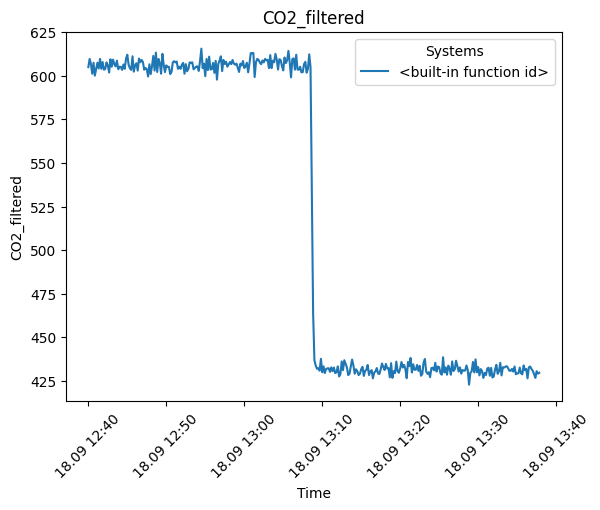

In [15]:
sensor_id = 4

#calibration time
start_date = datetime(2023, 9, 18, 12, 40, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 18, 13, 38, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(sensor_id,start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [16]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


606.3494186046512
606.655357142857
432.1545454545457
431.4330434782609


(1.0476405439513985, -24.60674834817263)

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KeyError: 'y'

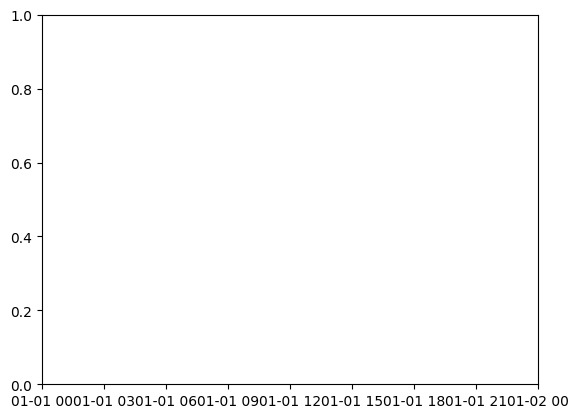

In [17]:
sensor_id = 5

#calibration time
start_date = datetime(2023, 6, 12, 0, 19, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 6, 12, 23, 6, 0).replace(tzinfo=timezone.utc)

df_copy = extract_calibration_period(sensor_id,start_date, end_date)

plot_sensor_measurement(df_copy,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter=None)

In [18]:
# 600 ppm
measured_values = [None, None]
true_values = [427.38, 610.95]

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


# 400 ppm

data = df_copy.filter(pl.col("system name") == f"tum-esm-midcost-raspi-{sensor_id}").filter(pl.col("CO2_filtered") > 0).filter(pl.col("CO2_filtered") < 550).get_column("CO2_filtered").to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)


ZeroDivisionError: division by zero

# After Database Migration

417.8919075144511
417.30265486725654
597.7372222222222
597.508547008547


/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

(1.0186681346471844, 2.287082983054006)

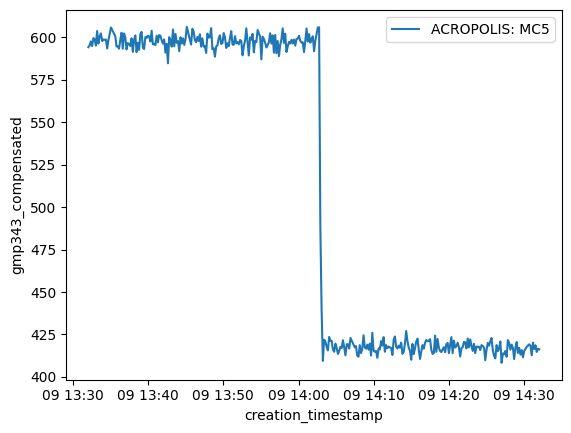

In [19]:
sensor_id = 5
cal_start = datetime(2023, 10, 9, 13, 32, 0).replace(tzinfo=timezone.utc)
cal_end = datetime(2023, 10, 9, 14, 32, 0).replace(tzinfo=timezone.utc)

acropolis_path = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/acropolis/"

df = pl.scan_parquet(os.path.join(acropolis_path, "pivot_measurements.parquet"))

df_copy = df.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(cal_start, cal_end)).filter(pl.col("gmp343_compensated") > 0)

sns.lineplot(data=df_copy.collect(), x="creation_timestamp", y="gmp343_compensated", label = f"ACROPOLIS: MC{sensor_id}")

measured_values = [None, None]
true_values = [427.38, 610.95]

# 400 ppm

data = df_copy.select(pl.col("gmp343_compensated")).filter(pl.col("gmp343_compensated") < 550).collect().to_series().to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)

# 600 ppm
data = df_copy.select(pl.col("gmp343_compensated")).filter(pl.col("gmp343_compensated") > 550).collect().to_series().to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)

In [ ]:
sensor_id = 5
cal_start = datetime(2023, 10, 9, 13, 32, 0).replace(tzinfo=timezone.utc)
cal_end = datetime(2023, 10, 9, 14, 32, 0).replace(tzinfo=timezone.utc)

acropolis_path = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/acropolis/"

df = pl.scan_parquet(os.path.join(acropolis_path, "pivot_measurements.parquet"))

df_copy = df.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(cal_start, cal_end)).filter(pl.col("gmp343_compensated") > 0)

sns.lineplot(data=df_copy.collect(), x="creation_timestamp", y="gmp343_compensated", label = f"ACROPOLIS: MC{sensor_id}")

measured_values = [None, None]
true_values = [427.38, 610.95]

# 400 ppm

data = df_copy.select(pl.col("gmp343_compensated")).filter(pl.col("gmp343_compensated") < 550).collect().to_series().to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[0] = sum(data_cut) / len(data_cut)

# 600 ppm
data = df_copy.select(pl.col("gmp343_compensated")).filter(pl.col("gmp343_compensated") > 550).collect().to_series().to_list()

data_cut = data[int(len(data)*0.3):int(len(data)*0.95)]

print(sum(data) / len(data))
print(sum(data_cut) / len(data_cut))
measured_values[1] = sum(data_cut) / len(data_cut)


two_point_calibration(measured_values, true_values)